<a href="https://colab.research.google.com/github/osilian/ml4sc-project/blob/master/disc-benchmark-files/identification_NARX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load required packages
import torch
from torch import nn
from matplotlib import pyplot as plt
plt.rcParams['text.usetex'] = False
import numpy as np

#print(torch.accelerator.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#!nvidia-smi

cuda


### Create Datasets and apply Preprocessing

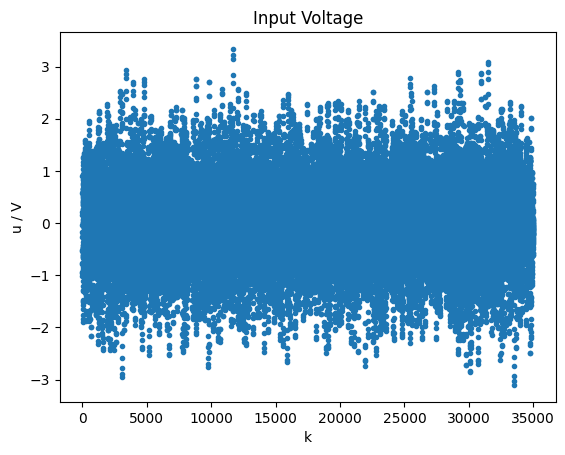

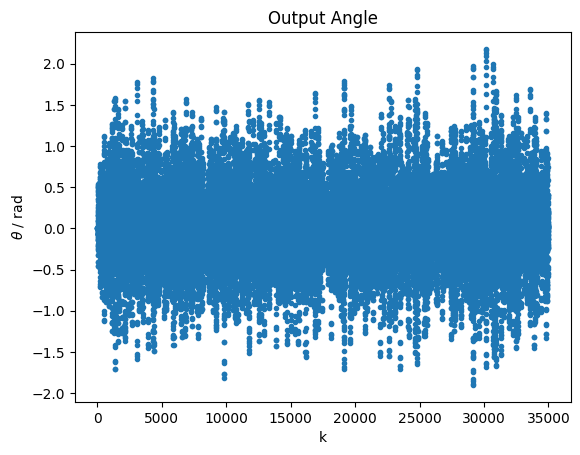

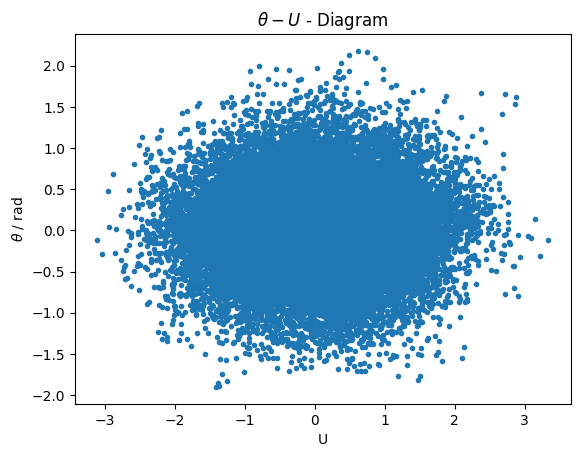

In [2]:
# Load Benchmark Data

out = np.load('training-val-test-data.npz')
th_train = out['th'] #th[0],th[1],th[2],th[3],...
u_train = out['u'] #u[0],u[1],u[2],u[3],...

# Plot Data
plt.plot(u_train,'.')
plt.title('Input Voltage')
plt.xlabel('k')
plt.ylabel('u / V')
plt.show()

plt.plot(th_train,'.')
plt.title('Output Angle')
plt.xlabel('k')
plt.ylabel(r'$\theta$ / rad')
plt.show()

plt.plot(u_train,th_train,'.')
plt.title(r'$\theta - U$ - Diagram')
plt.xlabel('U')
plt.ylabel(r'$\theta$ / rad')
plt.show()


def create_IO_data(u,y,na,nb):
    X = []
    Y = []
    for k in range(max(na,nb), len(y)):
        X.append(np.concatenate([u[k-nb:k],y[k-na:k]]))
        Y.append(y[k])
    return np.array(X), np.array(Y)
'''
# Apply Preprocessing - normalization
u_mean = np.mean(u_train)
th_mean = np.mean(th_train)
u_std  = np.std(u_train)
th_std = np.std(th_mean)
u_train = (u_train-u_mean)/u_std
th_train = (th_train - th_mean)/th_std
'''
def create_search_data(na, nb, uTrain=u_train, yTrain=th_train, testSize=0.2):
    # Create Time-Series Datasets
    Xdata, Ydata = create_IO_data(uTrain, yTrain, na, nb)

    # split into training in validation data
    from sklearn import model_selection
    Xtrain, Xval, Ytrain, Yval = model_selection.train_test_split(Xdata, Ydata, shuffle=True, test_size=testSize,random_state=42)

    Xtrain, Xval, Ytrain, Yval = [torch.as_tensor(x,dtype=torch.float32,device=device) for x in [Xtrain, Xval, Ytrain, Yval]] #convert it to torch arrays
    return Xtrain, Xval, Ytrain, Yval



### Create and Train NARX NN

In [3]:
class narxNetwork(nn.Module):
    def __init__(self, na, nb, n_hidden_nodes,activation=nn.Sigmoid): #a)
        super(narxNetwork,self).__init__() #a)
        #self.lay1 = nn.Linear(n_in,n_hidden_nodes).double() #a)
        #self.lay2 = nn.Linear(n_hidden_nodes,1).double() #a)

        seq = [nn.Linear(na+nb,n_hidden_nodes), activation()]
        seq.append(nn.Linear(n_hidden_nodes,1))

        self.narx_net = nn.Sequential(*seq)


    def forward(self,x): #a)
        #x = concatenated [upast and ypast] #a)
        y = self.narx_net(x)[:,0]
        return y #a)






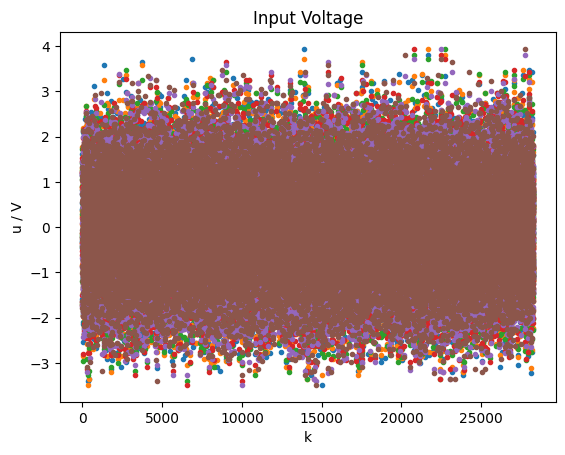

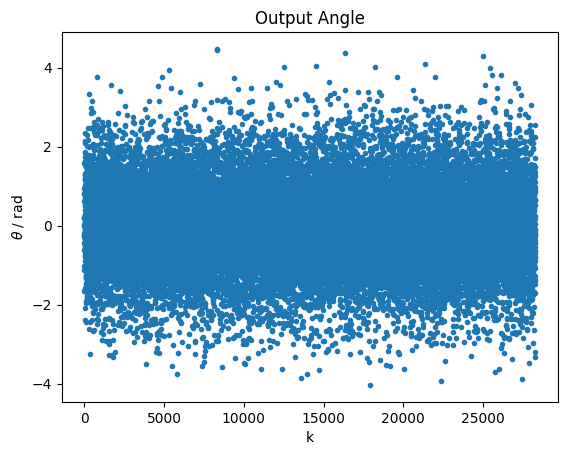

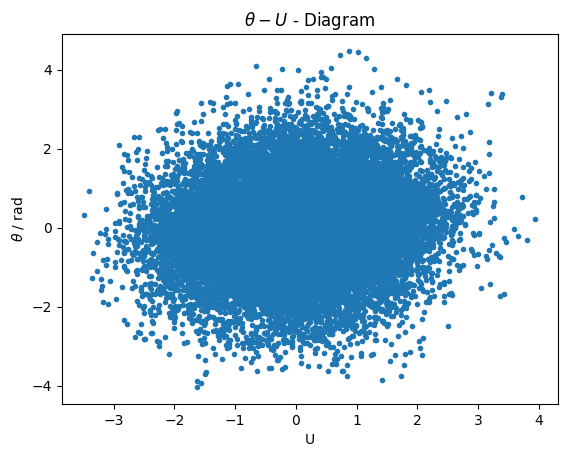

After Normalization - umean =-0.001617155154235661, ustd =1.0
After Normalization - ymean - X =-0.0007072892040014267, ystd -X =0.9991992712020874
After Normalization - ymean - y =2.16007767228632e-09, ystd -y =0.9999999403953552


In [4]:
n_hidden_nodes = 100 #a)
na, nb = 6, 6
testStartIndex = len(u_train)//20
u_train_small = u_train[:-(testStartIndex+1)]
y_train_small = th_train[:-(testStartIndex+1)]

Xtrain, Xval, Ytrain, Yval = create_search_data(na, nb, uTrain=u_train_small, yTrain=y_train_small, testSize=0.15)
u_train_mean = torch.mean(Xtrain[:,:nb]).item()
u_train_std = torch.std(Xtrain[:,:nb]).item()
y_train_mean = torch.mean(Ytrain).item()
y_train_std = torch.std(Ytrain).item()
class dataNormalization():
    def __init__(self, x_min, x_max, y_min, y_max):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max

    def normalize(self, XData, YData):
        #Xnorm = 2 * (XData - self.x_min) / (self.x_max - self.x_min) - 1 # -1 and * 2 to always normalize into (-1,1) no matter what the smallest x_min is
        #Ynorm = 2 * (YData - self.y_min) / (self.y_max - self.y_min) - 1
        unorm = (XData[:,:nb]-u_train_mean)/u_train_std
        yPastNorm = (XData[:,nb:] - y_train_mean) / y_train_std
        Xnorm = torch.cat((unorm, yPastNorm), dim=1)
        Ynorm = (YData-y_train_mean)/y_train_std
        #Xnorm = XData
        #Ynorm = YData
        return Xnorm, Ynorm

    def denormalize(self, YData_norm):
        #YData = 0.5 * (YData_norm + 1) * (self.y_max - self.y_min) + self.y_min
        YData = YData_norm*y_train_std + y_train_mean
        #YData = YData_norm
        return YData
x_min = -3 #torch.min(torch.min(Xtrain)).item()
x_max = +3 #torch.max(torch.min(Xtrain)).item()
y_min = -2/3*np.pi  #torch.min(torch.min(Ytrain)).item()
y_max = +2/3*np.pi   #torch.max(torch.min(Ytrain)).item()
dataNorm = dataNormalization(x_min,x_max,y_min,y_max)

Xtrain_norm, Ytrain_norm = dataNorm.normalize(Xtrain, Ytrain)
Xval_norm, Yval_norm = dataNorm.normalize(XData=Xval, YData=Yval)
#Xtrain_norm, Ytrain_norm = [x.to(device) for x in [Xtrain_norm, Ytrain_norm]]

# Plot Data
plt.plot(Xtrain_norm[:,:nb].cpu(),'.')
plt.title('Input Voltage')
plt.xlabel('k')
plt.ylabel('u / V')
plt.show()

plt.plot(Ytrain_norm.cpu(),'.')
plt.title('Output Angle')
plt.xlabel('k')
plt.ylabel(r'$\theta$ / rad')
plt.show()

plt.plot(Xtrain_norm[:,nb-1].cpu(),Ytrain_norm.cpu(),'.')
plt.title(r'$\theta - U$ - Diagram')
plt.xlabel('U')
plt.ylabel(r'$\theta$ / rad')
plt.show()

print(f'After Normalization - umean ={torch.mean(Xtrain_norm[:,nb-1]).item()}, ustd ={torch.std(Xtrain_norm[:,:nb]).item()}')
print(f'After Normalization - ymean - X ={torch.mean(Xtrain_norm[:,nb:]).item()}, ystd -X ={torch.std(Xtrain_norm[:,nb:]).item()}')
print(f'After Normalization - ymean - y ={torch.mean(Ytrain_norm[:]).item()}, ystd -y ={torch.std(Ytrain_norm[:]).item()}')

In [8]:
model = narxNetwork(na, nb, n_hidden_nodes,activation=nn.ReLU) #a=)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters()) #a)
#optimizer = torch.optim.SGD(model.named_parameters(), lr=0.01, momentum=0.9)
epochs = 30*10**3 #a)
for epoch in range(epochs): #a)
    Loss = torch.mean((model(Xtrain_norm)-Ytrain_norm)**2) #a)
    optimizer.zero_grad() #a)
    Loss.backward() #a)
    optimizer.step() #a)
    RMS_val = torch.mean((model(Xval_norm)-Yval_norm)**2).item()**0.5
    if epoch%1000==0: #a) monitor
        print(f'Epoch {epoch}, RMS Training: {Loss.item()}, RMS Val: {RMS_val}') #a)


Epoch 0, RMS Training: 1.0747324228286743, RMS Val: 1.0207287416918884
Epoch 1000, RMS Training: 0.0006415412062779069, RMS Val: 0.02770260154363514
Epoch 2000, RMS Training: 0.0002044923894573003, RMS Val: 0.015180189829879396
Epoch 3000, RMS Training: 0.00011475585051812232, RMS Val: 0.010979584107476077
Epoch 4000, RMS Training: 7.51064217183739e-05, RMS Val: 0.008941178830181699
Epoch 5000, RMS Training: 5.4509462643181905e-05, RMS Val: 0.007508389273357254
Epoch 6000, RMS Training: 4.565158815239556e-05, RMS Val: 0.006761679762458462
Epoch 7000, RMS Training: 4.103222818230279e-05, RMS Val: 0.006353074521464313
Epoch 8000, RMS Training: 3.914662011084147e-05, RMS Val: 0.00624201397563615
Epoch 9000, RMS Training: 4.035455276607536e-05, RMS Val: 0.006237233009885129
Epoch 10000, RMS Training: 3.667382770800032e-05, RMS Val: 0.006041874457805834
Epoch 11000, RMS Training: 3.568588363123126e-05, RMS Val: 0.005961755536445437
Epoch 12000, RMS Training: 3.517346704029478e-05, RMS Val: 

In [5]:

# Code from Exercise Set L3
def fit(net, X_data, Y_data, X_val, Y_val, lr, epochs=10*10**3):
    optimizer = torch.optim.Adam(net.parameters(),lr=lr)
    best_state = None
    best_loss = float('inf')

    for epoch in range(1,epochs+1):
        loss = torch.mean((net(X_data)-Y_data)**2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch%1000==0:
            loss_val = torch.mean((net(X_val)-Y_val)**2).item()**0.5 #RMS
            if loss_val<best_loss:
                from copy import deepcopy
                best_state = deepcopy(net.state_dict())
                best_loss = loss_val
            print(f'epoch={epoch:5}, loss={loss.item()**0.5:.2f}')
    if best_state:
        net.load_state_dict(best_state)
    return net

import functools
@functools.lru_cache(maxsize=500, typed=False)
def test(X_train, Y_train, X_val, Y_val, na=2, nb=2, n_hidden_nodes=20, activation=nn.Tanh, lr=1e-3):
    net = narxNetwork(na, nb, n_hidden_nodes, activation) #a=)
    net = net.to(device)
    net = fit(net, X_train, Y_train, X_val, Y_val, lr) #a=)
    RMS = torch.mean((net(X_val)-Y_val)**2).item()**0.5 #a=)
    return RMS #a=)


current_best = dict(na=5, nb=5, n_hidden_nodes=5, activation=nn.Sigmoid, lr=1e-3)
choices_dict = dict(na=[1,2,3,4,5,6,7,8], \
                nb=[1,2,3,4,5,6,7,8], \
                n_hidden_nodes=[50, 100], \
                activation=[nn.ReLU], \
                lr = [1e-3]
                )
'''
choices_dict = dict(na=[3, 6, 9, 12, 15], \
                nb=[3, 6, 9, 12, 15], \
                n_hidden_nodes=[10, 15, 20, 30, 50, 100], \
                activation=[nn.Sigmoid, nn.Tanh, nn.ReLU], \
                lr = [1e-3, 1e-4]
                )
'''
import itertools
gridKeys = choices_dict.keys()
grid = list(itertools.product(*choices_dict.values()))

# rmse_matrix = np.zeros((len(choices_dict["na"]), len(choices_dict["nb"])))

best_score = float('inf')
best_params = None
results = []
import copy
for params in grid:
    choice = dict(zip(gridKeys,params))
    # now = copy.deepcopy(current_best) #create a new dict
    # now[name] = choice #put choice in the correct place
    print('optimizing...',choice)

    # create dataset
    Xtrain, Xval, Ytrain, Yval = create_search_data(choice['na'],choice['nb'])
    Xtrain_norm, Ytrain_norm = dataNorm.normalize(Xtrain, Ytrain)
    Xval_norm, Yval_norm = dataNorm.normalize(Xval,Yval)
    rmse = test(Xtrain_norm, Ytrain_norm, Xval_norm, Yval_norm,**choice)
    results.append((choice, rmse)) #add it to results

    #print('done with loop for option', name)
    #print('\n'.join([f'choice={c} result={r:.5}' for c,r in zip(choices,results)]))
    # pick = choices[np.argmin(results)]
    # print(f'picking = {pick} {name}')
    #current_best[name] = pick

    if rmse < best_score:
        best_score = rmse
        best_params = choice



optimizing... {'na': 1, 'nb': 1, 'n_hidden_nodes': 50, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'lr': 0.001}
epoch= 1000, loss=0.24
epoch= 2000, loss=0.24
epoch= 3000, loss=0.24
epoch= 4000, loss=0.24
epoch= 5000, loss=0.24
epoch= 6000, loss=0.24
epoch= 7000, loss=0.24
epoch= 8000, loss=0.24
epoch= 9000, loss=0.24
epoch=10000, loss=0.24
optimizing... {'na': 1, 'nb': 1, 'n_hidden_nodes': 100, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'lr': 0.001}
epoch= 1000, loss=0.24
epoch= 2000, loss=0.24
epoch= 3000, loss=0.24
epoch= 4000, loss=0.24
epoch= 5000, loss=0.24
epoch= 6000, loss=0.24
epoch= 7000, loss=0.24
epoch= 8000, loss=0.24
epoch= 9000, loss=0.24
epoch=10000, loss=0.24
optimizing... {'na': 1, 'nb': 2, 'n_hidden_nodes': 50, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'lr': 0.001}
epoch= 1000, loss=0.22
epoch= 2000, loss=0.22
epoch= 3000, loss=0.22
epoch= 4000, loss=0.22
epoch= 5000, loss=0.22
epoch= 6000, loss=0.22
epoch= 7000, loss=0.22


In [9]:
import pickle
with open("grid_search_nanb_fine","wb") as f:
  pickle.dump(results,f)

print(best_params)
#model = narxNetwork(best_params['na'],best_params['nb'],best_params['n_hidden_nodes'],best_params['activation'])
model = narxNetwork(best_params['na'],best_params['nb'],50,best_params['activation'])
model = model.to(device)
na, nb = best_params['na'], best_params['nb']

Xtrain, Xval, Ytrain, Yval = create_search_data(best_params['na'],best_params['nb'],testSize=0.3)
Xtrain_norm, Ytrain_norm = dataNorm.normalize(Xtrain, Ytrain)
Xval_norm, Yval_norm = dataNorm.normalize(Xval,Yval)

optimizer = torch.optim.Adam(model.parameters())
epochs = 20*10**3 #a)
for epoch in range(epochs): #a)
    Loss = torch.mean((model(Xtrain_norm)-Ytrain_norm)**2) #a)
    optimizer.zero_grad() #a)
    Loss.backward() #a)
    optimizer.step() #a)
    if epoch%1000==0: #a) monitor
        print(epoch,Loss.item()) #a)

{'na': 7, 'nb': 3, 'n_hidden_nodes': 100, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'lr': 0.001}
0 0.9855343699455261
1000 0.0011737210443243384
2000 0.00042575516272336245
3000 0.0001961887173820287
4000 0.00011477212683530524
5000 7.605420250911266e-05
6000 5.9491652791621163e-05
7000 5.114304440212436e-05
8000 4.697342592407949e-05
9000 4.31984371971339e-05
10000 4.329452713136561e-05
11000 4.037956387037411e-05
12000 3.848071719403379e-05
13000 3.7381651054602116e-05
14000 3.686943091452122e-05
15000 3.6318262573331594e-05
16000 3.879105133819394e-05
17000 3.48414687323384e-05
18000 3.494192787911743e-05
19000 3.45120279234834e-05


train prediction errors:
RMS: tensor(0.0028, device='cuda:0') radians
RMS: tensor(0.1602, device='cuda:0') degrees
NRMS: tensor(0.5836, device='cuda:0') %


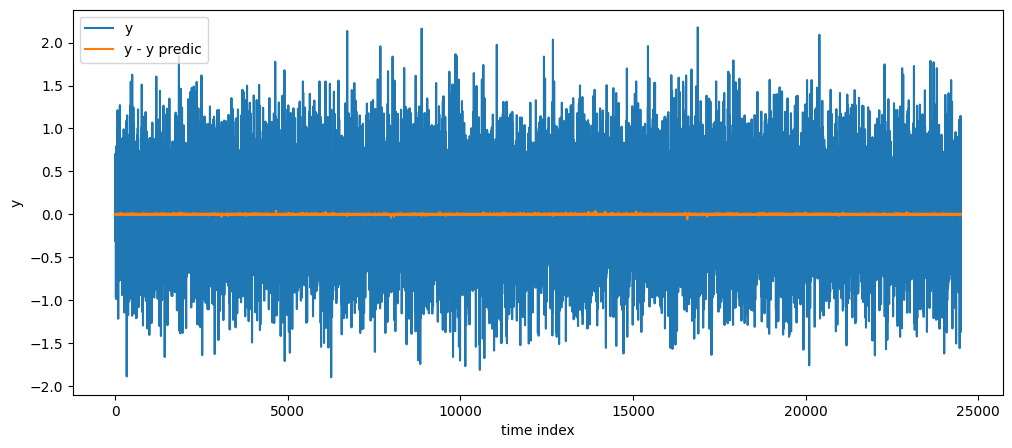

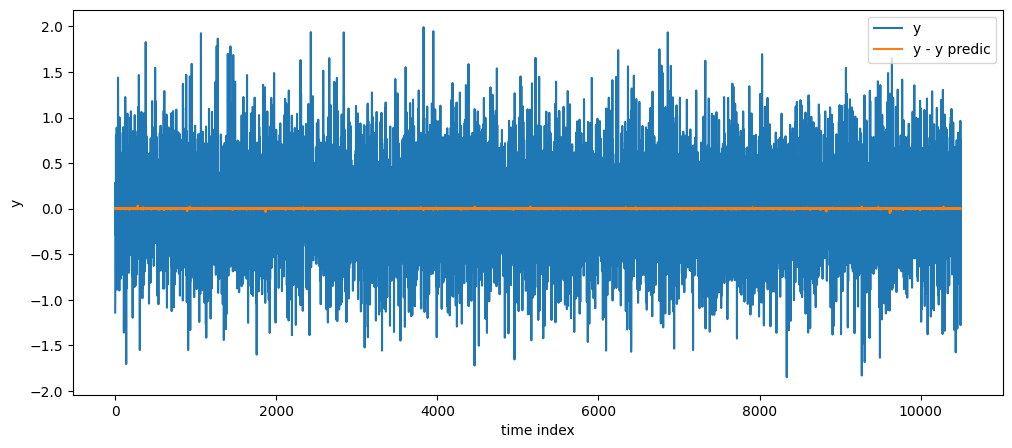

validation prediction errors:
RMS: 0.0028880278531444943 radians
RMS: 0.16547180710140744 degrees
NRMS: tensor(0.6011, device='cuda:0') %


In [10]:

#residual calculations and plotting
with torch.no_grad():
    Ytrain_pred_norm = model(Xtrain_norm)
    Ytrain_pred = dataNorm.denormalize(YData_norm=Ytrain_pred_norm)
    Ytrain = Ytrain.to('cuda')
    print('train prediction errors:')
    print('RMS:', torch.mean((Ytrain_pred-Ytrain)**2)**0.5,'radians')
    print('RMS:', torch.mean((Ytrain_pred-Ytrain)**2)**0.5/(2*np.pi)*360,'degrees')
    print('NRMS:', torch.mean((Ytrain_pred-Ytrain)**2)**0.5/Ytrain.std()*100,'%')
    res = Ytrain_pred - Ytrain #b)
    plt.figure(figsize=(12,5)) #b)
    plt.plot(Ytrain.cpu()) #b)
    plt.plot(res.cpu()) #b)
    plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y predic'])#b)
    plt.show() #b)

    Xval_norm, _ = dataNorm.normalize(XData=Xval, YData=Yval)
    Yval_pred_norm = model(Xval_norm)
    Yval_pred = dataNorm.denormalize(Yval_pred_norm)
    Yval = Yval.to('cuda')
    res = Yval_pred - Yval #b)
    plt.figure(figsize=(12,5)) #b)
    plt.plot(Yval.cpu()) #b)
    plt.plot(res.cpu()) #b)
    plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y predic'])#b)
    plt.show() #b)
    print('validation prediction errors:')
    print('RMS:', torch.mean((Yval_pred-Yval)**2).item()**0.5,'radians')
    print('RMS:', torch.mean((Yval_pred-Yval)**2).item()**0.5/(2*np.pi)*360,'degrees')
    print('NRMS:', torch.mean((Yval_pred-Yval)**2).item()**0.5/Yval.std()*100,'%')

trained simulation errors:
RMS: 0.0165795362566153 radians
RMS: 0.9499374537881846 degrees
NRMS: 3.458845276058456 %


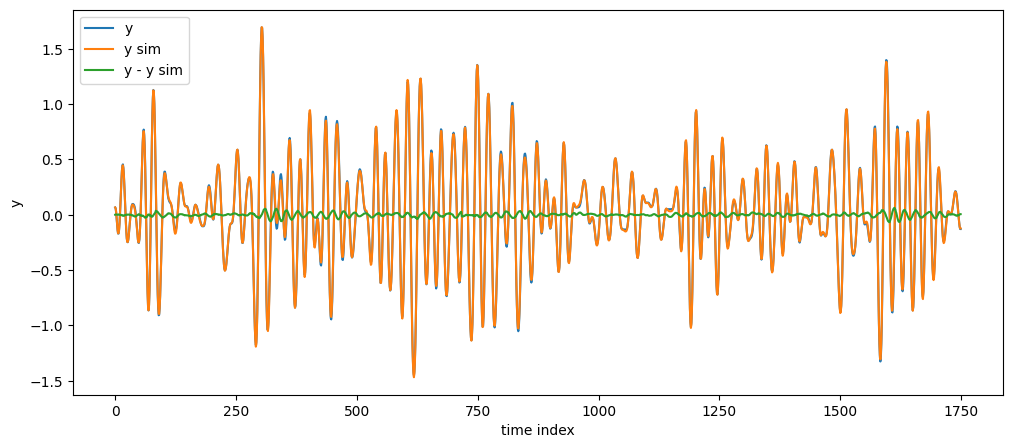

test simulation errors:
RMS: 0.012134547915821085 radians
RMS: 0.6952583818758175 degrees
NRMS: 2.5315257969894023 %


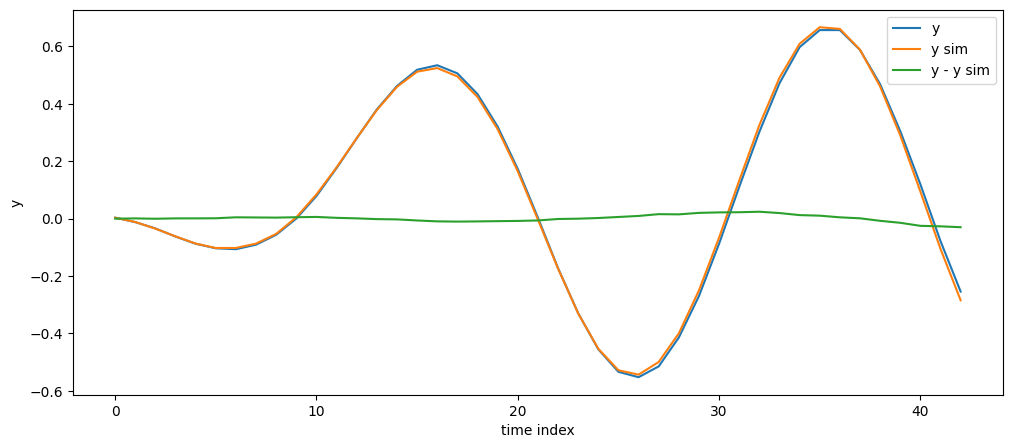

In [11]:
# Set up simulation for identified net
#### What's done with the na and nb here???
# Simulation Test
'''
out = np.load('/content/hidden-test-prediction-submission-file.npz')
th_train = out['thpast'][:,0] #th[0],th[1],th[2],th[3],...
u_train = out['upast'][:,0] #u[0],u[1],u[2],u[3],...
'''
out = np.load('training-val-test-data.npz')
th_train = out['th'] #th[0],th[1],th[2],th[3],...
u_train = out['u'] #u[0],u[1],u[2],u[3],...

data = np.load('/content/hidden-test-simulation-submission-file.npz')
u_test = data['u']
th_test = data['th'] #only the first 50 values are filled the rest are zeros

def simulation_IO_model(f, ulist, ylist, skip=50):
    upast = ulist[skip-nb:skip].tolist() #good initialization
    ypast = ylist[skip-na:skip].tolist()
    Y = ylist[:skip].tolist()
    for u in ulist[skip:]:
        x = np.concatenate([upast,ypast],axis=0)
        x = torch.as_tensor(x[None,:],dtype=torch.float32, device=device)
        x_norm,_ = dataNorm.normalize(x,x)
        ypred = f(x_norm)[0].cpu()
        ypred = dataNorm.denormalize(ypred.detach().numpy())
        Y.append(ypred)
        upast.append(u)
        upast.pop(0)
        ypast.append(ypred)
        ypast.pop(0)
    return np.array(Y)
import math
skip = len(u_train) - testStartIndex
#skip = max(na,nb)
th_train_sim = simulation_IO_model(lambda x: model(x[None,:])[0], u_train, th_train, skip=skip)
print('trained simulation errors:')
print('RMS:', np.mean((th_train_sim[skip:]-th_train[skip:])**2)**0.5,'radians')
print('RMS:', np.mean((th_train_sim[skip:]-th_train[skip:])**2)**0.5/(2*np.pi)*360,'degrees')
print('NRMS:', np.mean((th_train_sim[skip:]-th_train[skip:])**2)**0.5/th_train.std()*100,'%')
# Plotting
res = th_train_sim[skip:] - th_train[skip:] #b)
plt.figure(figsize=(12,5)) #b)
plt.plot(th_train[skip:]) #b)
plt.plot(th_train_sim[skip:])
plt.plot(res) #b)
plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y sim','y - y sim'])#b)
plt.show() #b)

skip = max(na,nb)
th_test_sim = simulation_IO_model(lambda x: model(x[None,:])[0], u_test, th_test, skip=skip)
print('test simulation errors:')
print('RMS:', np.mean((th_test_sim[skip:50]-th_test[skip:50])**2)**0.5,'radians')
print('RMS:', np.mean((th_test_sim[skip:50]-th_test[skip:50])**2)**0.5/(2*np.pi)*360,'degrees')
print('NRMS:', np.mean((th_test_sim[skip:50]-th_test[skip:50])**2)**0.5/th_train.std()*100,'%')
# Plotting
res = th_test_sim[skip:50] - th_test[skip:50] #b)
plt.figure(figsize=(12,5)) #b)
plt.plot(th_test[skip:50]) #b)
plt.plot(th_test_sim[skip:50])
plt.plot(res) #b)
plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y sim','y - y sim'])#b)
plt.show() #b)

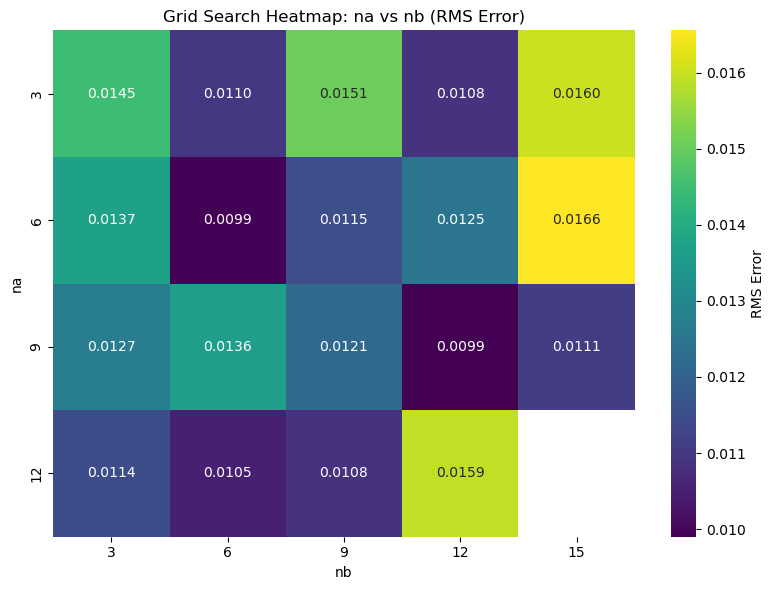

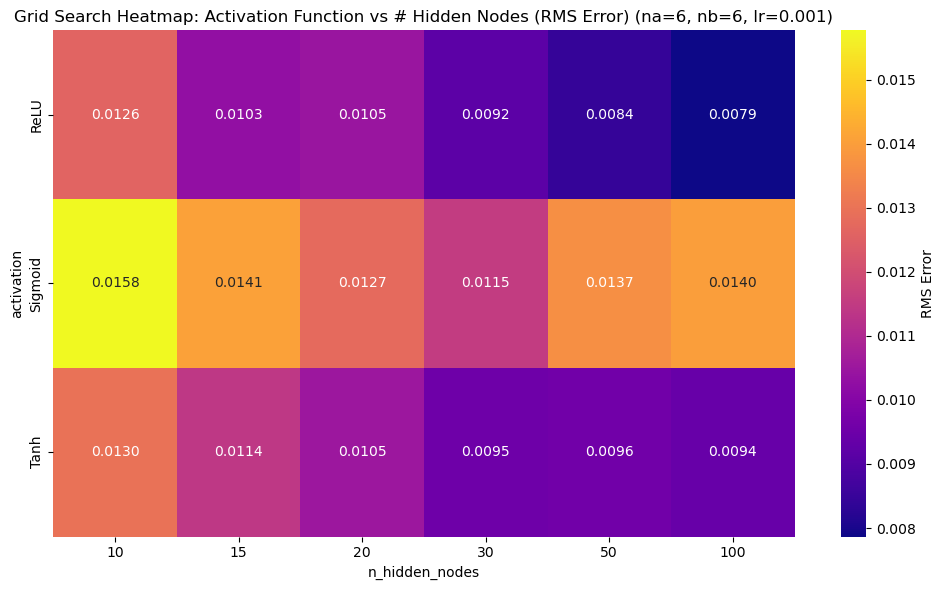

In [ ]:
# import saved grid search
import pickle

file_path = 'grid_search'

with open(file_path, 'rb') as f:
    results_grid = pickle.load(f)

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch

# for activation and hidden_nodes not specified, uses averaging

df = pd.DataFrame([
    {
        'na': params['na'],
        'nb': params['nb'],
        'RMS': rms
    }
    for params, rms in results_grid
    if (params['activation']==torch.nn.ReLU) and (params['lr']==0.001)  and (params['n_hidden_nodes'] == 10)
])

pivot_table = df.pivot_table(index='na', columns='nb', values='RMS')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="viridis", cbar_kws={'label': 'RMS Error'})
plt.title('Grid Search Heatmap: na vs nb (RMS Error)')
plt.xlabel('nb')
plt.ylabel('na')
plt.tight_layout()
plt.show()


df = pd.DataFrame([
    {
        'activation': str(params['activation']).split('.')[-1].split("'")[0],
        'n_hidden_nodes': params['n_hidden_nodes'],
        'RMS': rms
    }
    for params, rms in results_grid
    if params['lr'] == 0.001
])

pivot_table = df.pivot_table(index='activation', columns='n_hidden_nodes', values='RMS')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="plasma", cbar_kws={'label': 'RMS Error'})
plt.title('Grid Search Heatmap: Activation Function vs # Hidden Nodes (RMS Error) (na=6, nb=6, lr=0.001)')
plt.xlabel('n_hidden_nodes')
plt.ylabel('activation')
plt.tight_layout()
plt.show()
